In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm
import geopandas as gpd
import matplotlib as plt
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from sklearn.neighbors import KDTree

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

laptop = 'forgach1mar822'

In [19]:
pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/overpass_data_gpd.p'
overpass_gdf = pd.read_pickle(pickle_dirstring)

pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/bubi_data.p'
bubi_data_df = pd.read_pickle(pickle_dirstring)

pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/station_data_dists.p'
station_data_df = pd.read_pickle(pickle_dirstring)

overpass_gdf.loc[:, overpass_gdf.columns != 'geometry'].head()
bubi_data_df.head(2)
station_data_df.head(2)

,lat,lon,tags_light_rail,tags_name,tags_railway,tags_train,tags_bus,tags_tram,tags_trolleybus,tags_subway,atm,bank,bar,cafe,cinema,fast_food,pharmacy,post_office,pub,restaurant,theatre
0,47.507152,19.039409,1.0,Batthyány tér,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.469158,19.243233,NaN,Rákoshegy,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.525015,19.227709,NaN,Kisherceg vendéglő,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,47.566302,19.047360,NaN,Aquincum,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.598553,19.055045,1.0,Békásmegyer,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Berles_UID,Start_station,End_station,UID,Bike_number,Ticket,start_time,end_time,time
0,7367458,0709-Rumbach Sebestyén utca - BKK,0709-Rumbach Sebestyén utca - BKK,858994.0,86325.0,féléves bérlet – promóciós,2014-09-08 00:00:32,2014-09-08 00:01:34,0 days 00:01:02
4,7368289,0709-Rumbach Sebestyén utca - BKK,0709-Rumbach Sebestyén utca - BKK,858913.0,86405.0,féléves bérlet – promóciós,2014-09-08 06:55:50,2014-09-08 06:57:22,0 days 00:01:32


,District,Station_id,Station,Rack number,lat,lon,Start date,End date,Move date,Shutdown start,Shutdown end,geometry,height,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_stations_near,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby
0,1.0,101.0,0101-Batthyány tér,28.0,47.506406,19.039172,2014-09-08,NaT,2015-01-15,2015-02-01,2015-04-22,POINT (19.03917 47.50641),97.0,40.0,52.0,1293.0,33.0,52.0,2026.0,58.0,16.0,107.0,454.0,100.0,574.0,89.0,121.0,110.0,166.0,85.0,776.0,334.0,0,4,5,0,4,2,0,2,5,2,0,3,0,2,2,1,4,6,0
1,1.0,102.0,0102-Szilágyi Dezső tér,15.0,47.503424,19.039714,2014-09-08,NaT,NaT,NaT,NaT,POINT (19.03971 47.50342),106.0,318.0,129.0,1157.0,300.0,129.0,1795.0,362.0,245.0,300.0,134.0,137.0,389.0,311.0,327.0,420.0,147.0,34.0,619.0,334.0,0,0,4,0,0,4,0,0,2,0,1,3,0,0,0,0,2,9,0


## Create Grid

In [20]:
min_lat = min(station_data_df.lat) - 0.01
max_lat = max(station_data_df.lat) + 0.01
min_lon = min(station_data_df.lon) - 0.01
max_lon = max(station_data_df.lon) + 0.01

In [21]:
np.ceil((max_lat - min_lat)/0.01)

10.0

In [22]:
steps_lat = int(np.ceil((max_lat - min_lat)/0.0013))
lat_list = np.linspace(min_lat, max_lat, num = steps_lat)

steps_lon = int(np.ceil((max_lon - min_lon)/0.0013))
lon_list = np.linspace(min_lon, max_lon, num = steps_lon)

In [23]:
%%time
grid_list = []
for lon in lon_list:
    for lat in lat_list:
        grid_list.append([lon, lat])

Wall time: 3 ms


In [24]:
%%time
grid_list_df = pd.DataFrame(grid_list, columns = ['lon', 'lat'])
grid_list_df['lon'] = grid_list_df['lon'].astype('float64')
grid_list_df['lat'] = grid_list_df['lat'].astype('float64')
#coord_list_df.dtypes
grid_list_df.head()

Wall time: 19 ms


,lon,lat
0,18.998945,47.458348
1,18.998945,47.459659
2,18.998945,47.460969
3,18.998945,47.462280
4,18.998945,47.463590


In [25]:
len(grid_list_df)

7029

In [26]:
grid_list_df = gpd.GeoDataFrame(grid_list_df, geometry=gpd.points_from_xy(grid_list_df.lon, grid_list_df.lat))

<AxesSubplot:>

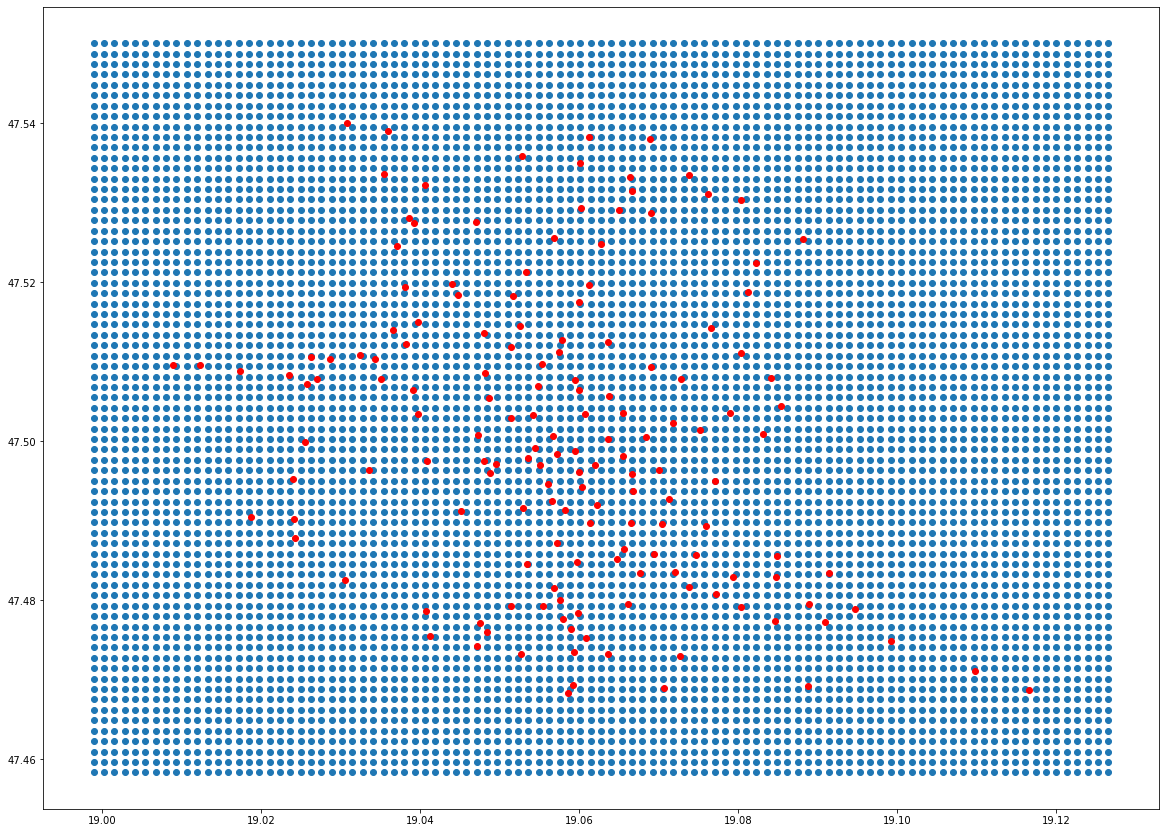

In [28]:
ax = grid_list_df.plot(figsize = (20,20))
station_data_df.plot(color = 'red', ax=ax)
plt.pyplot.savefig("grid.png")

## Calculate distances from Bubi and amenities for the Grid

### Amenities

In [29]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Inputs in lat, lon format. 
    :params lat1, lon1, lat2, lon2: floats; lat and lon of the two points
    :return: float; distance in metres. 
    """
    try:
        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [float(lon1), float(lat1), float(lon2), float(lat2)])

        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371000 # Radius of earth in meters. Use 3956 for miles
        return int(c * r)
    except Exception as e:
        print(e)
        return None 
    
def haversine_manhattan(lat1,lon1,lat2,lon2):
    """
    """
    lat_dist = haversine(lat1, lon1, lat1, lon2)
    lon_dist = haversine(lat1, lon1, lat2, lon1)
    return (lat_dist+lon_dist)

In [30]:
amenity_list = ['tags_light_rail', 'tags_railway', 'tags_train', 'tags_bus', 'tags_tram', 'tags_trolleybus', 'tags_subway', 'atm', 'bank', 'bar', 'cafe', 'cinema', 'fast_food', 
                'pharmacy', 'post_office', 'pub', 'restaurant', 'theatre']

In [208]:
%%time
grid_list_df = grid_list_df.reset_index(drop=True)

for i in tqdm(amenity_list):
    X = overpass_gdf[overpass_gdf[i] == 1].loc[:,['lat','lon']]
 
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree',n_jobs=-1, metric = lambda a,b:haversine(a[0],a[1],b[0],b[1])).fit(X)
    distances, indices = nbrs.kneighbors(grid_list_df.loc[:,['lat','lon']])
    
    #Make a dataframe with distance from amenities data
    temp_nb_df = pd.DataFrame(overpass_gdf[overpass_gdf[i] == 1].reset_index(drop=True).iloc[indices.flatten()][['lat', 'lon']])
    temp_nb_df = temp_nb_df.reset_index(drop=True)
    
    grid_list_df[str(i)+'_dist'] = distances
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [06:15<00:00, 20.83s/it]

Wall time: 6min 15s


### Nearest Bubi

In [32]:
%%time
grid_list_df = grid_list_df.reset_index(drop=True)
X=station_data_df.loc[:,['lat','lon']]

station_data_df = station_data_df.reset_index(drop=True)

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree',n_jobs=-1, metric = lambda a,b:haversine(a[0],a[1],b[0],b[1])).fit(X)
distances, indices = nbrs.kneighbors(grid_list_df.loc[:,['lat','lon']])

#distances convert, because NN algorithm finds the nearest station which is itself
distances = distances[:,[1]]
indices = indices[:,[1]]

temp_nb_df = pd.DataFrame(grid_list_df.iloc[indices.flatten()][['lat', 'lon']])
temp_nb_df = temp_nb_df.reset_index(drop=True)

grid_list_df['nearest_bubi_dist'] = distances

Wall time: 5.94 s


## Amenities within 300 m

In [33]:
## BUBI STATIONS
from sklearn.neighbors import KDTree

points = station_data_df.loc[:,['lat','lon']].values.tolist()
tree = KDTree(points)
nearest_count = tree.query_radius(grid_list_df.loc[:,['lat','lon']],r=0.0027,count_only=True) #0.0001 assuming lats and longs are in decimal degrees, this corresponds to 11.1 meter
grid_list_df['bubi_nearby'] = nearest_count

In [34]:
## AMENITIES

amenity_list = ['tags_light_rail', 'tags_railway', 'tags_train', 'tags_bus', 'tags_tram', 'tags_trolleybus', 'tags_subway', 'atm', 'bank', 'bar', 'cafe', 'cinema', 'fast_food', 
                'pharmacy', 'post_office', 'pub', 'restaurant', 'theatre']

from sklearn.neighbors import KDTree

for i in amenity_list:
    points = overpass_gdf[overpass_gdf[i] == 1].loc[:,['lat','lon']].values.tolist()
    #points = overpass_gdf.loc[:,['lat','lon']].values.tolist()
    tree = KDTree(points)
    nearest_count = tree.query_radius(grid_list_df.loc[:,['lat','lon']],r=0.0027,count_only=True)
    grid_list_df[str(i)+'_nearby'] = nearest_count

## Calculate height for each point

In [35]:
pickle_dirstring = 'C:/Users/' + laptop + '/Downloads/Egyéb/PICKLE/coord_list.p'
coord_list_df = pd.read_pickle(pickle_dirstring)
coord_list_df.head(2)

,lon,lat,height
0,18.925139,47.612917,0.0
1,18.925139,47.612639,0.0


In [214]:
%%time
coord_list_df = coord_list_df.reset_index(drop=True)
X=coord_list_df.loc[:,['lat','lon']]

grid_list_df = grid_list_df.reset_index(drop=True)

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree',n_jobs=-1).fit(X)
distances, indices = nbrs.kneighbors(grid_list_df.loc[:,['lat','lon']])

#Make a dataframe with height data
temp_nb_df = pd.DataFrame(coord_list_df.height[indices.flatten()])
temp_nb_df = temp_nb_df.reset_index(drop=True)
grid_list_df['height'] = temp_nb_df['height']

Wall time: 21.7 s


<AxesSubplot:>

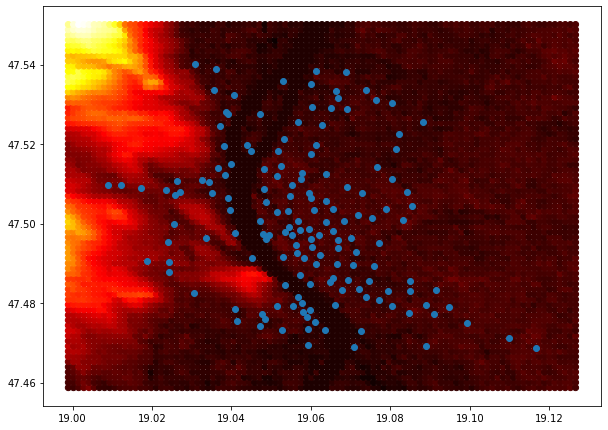

In [5]:
ax = grid_list_df.plot(column = grid_list_df.height, cmap = 'hot', figsize = (10,10))
station_data_df.geometry.plot(ax=ax)

In [38]:
%%time
from sklearn.ensemble import RandomForestRegressor
import pickle

filename = 'random_forest_gridCV_best.sav'
random_forest_1 = pickle.load(open(filename, 'rb'))

grid_list_df['prediction'] = random_forest_1.predict(grid_list_df[grid_list_df.columns[3:44]])

Wall time: 20 ms


In [13]:
grid_list_df.sort_values(by = 'prediction', ascending = False).head()

,lon,lat,geometry,tags_light_rail_dist,tags_railway_dist,tags_train_dist,tags_bus_dist,tags_tram_dist,tags_trolleybus_dist,tags_subway_dist,atm_dist,bank_dist,bar_dist,cafe_dist,cinema_dist,fast_food_dist,pharmacy_dist,post_office_dist,pub_dist,restaurant_dist,theatre_dist,nearest_bubi_dist,bubi_nearby,tags_light_rail_nearby,tags_railway_nearby,tags_train_nearby,tags_bus_nearby,tags_tram_nearby,tags_trolleybus_nearby,tags_subway_nearby,atm_nearby,bank_nearby,bar_nearby,cafe_nearby,cinema_nearby,fast_food_nearby,pharmacy_nearby,post_office_nearby,pub_nearby,restaurant_nearby,theatre_nearby,height,prediction
3295,19.058864,47.496355,POINT (19.05886 47.49635),1868.0,202.0,1568.0,202.0,202.0,202.0,233.0,16.0,36.0,56.0,20.0,258.0,22.0,152.0,132.0,53.0,9.0,107.0,252.0,4,0,3,0,4,3,2,1,12,4,21,23,1,6,1,1,15,35,4,120.0,445.116748
3086,19.054956,47.501597,POINT (19.05496 47.50160),1316.0,454.0,995.0,115.0,454.0,854.0,182.0,129.0,96.0,80.0,67.0,255.0,66.0,89.0,160.0,28.0,10.0,162.0,191.0,3,0,0,0,8,0,0,2,3,5,8,19,1,11,2,1,7,35,2,108.0,445.116748
3443,19.061469,47.504219,POINT (19.06147 47.50422),1683.0,184.0,760.0,35.0,184.0,1073.0,122.0,69.0,77.0,65.0,56.0,267.0,119.0,194.0,225.0,67.0,22.0,107.0,246.0,2,0,2,0,7,2,0,2,10,7,7,24,1,17,1,1,12,35,5,117.0,445.116748
3365,19.060166,47.495044,POINT (19.06017 47.49504),1839.0,54.0,1724.0,54.0,54.0,54.0,58.0,51.0,25.0,63.0,48.0,180.0,56.0,201.0,184.0,41.0,27.0,68.0,124.0,2,0,3,0,6,3,2,2,14,6,7,23,1,15,1,2,12,20,2,121.0,445.116748
3364,19.060166,47.493734,POINT (19.06017 47.49373),1699.0,48.0,1868.0,6.0,48.0,48.0,103.0,52.0,54.0,110.0,17.0,149.0,11.0,56.0,181.0,67.0,40.0,203.0,255.0,2,0,3,0,6,3,2,2,10,5,5,17,1,16,1,1,9,15,1,116.0,445.116748


<AxesSubplot:>

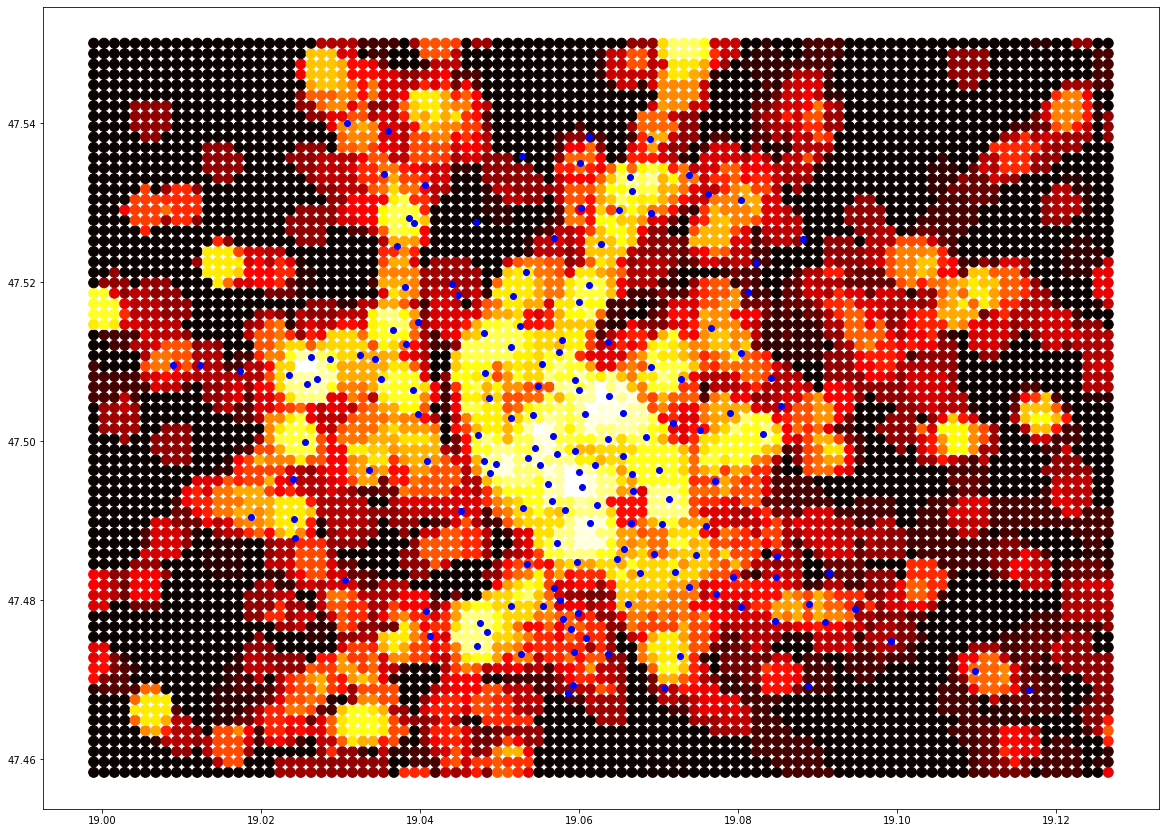

In [30]:
ax = grid_list_df.plot(column = grid_list_df.prediction, cmap = 'hot', figsize = (20,20), s = 100) #, legend = True)
station_data_df.plot(color = 'blue', ax=ax)

<AxesSubplot:>

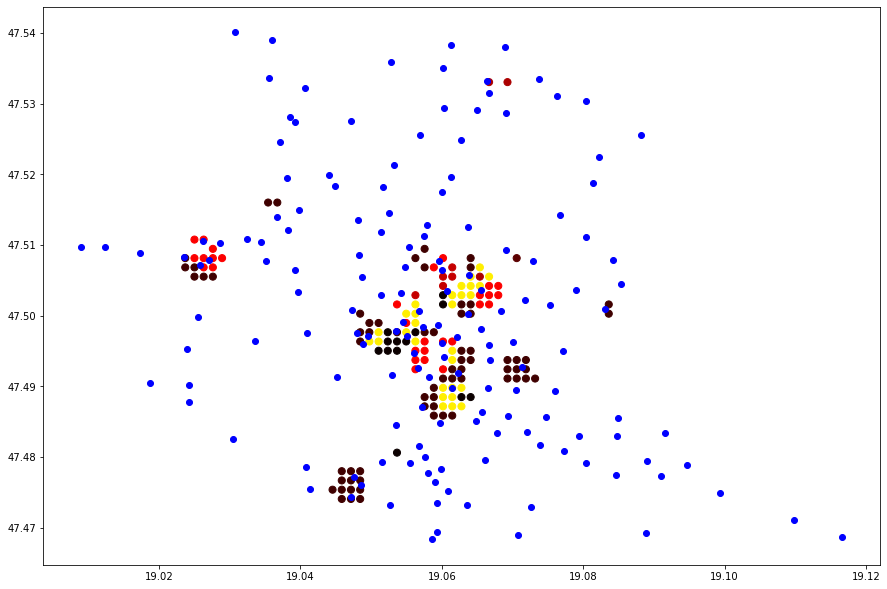

In [40]:
top_100 = grid_list_df.sort_values(by = 'prediction', ascending = False)[0:159]
ax = top_100.plot(column = top_100.prediction, cmap = 'hot', figsize = (15,15), s = 50)
station_data_df.plot(color = 'blue', ax=ax)
#top_100.to_csv("bad_prediction_result.csv")

In [67]:
%%time
#global index_list

grid_list_df = grid_list_df.sort_values(by = 'prediction', ascending = False).reset_index(drop = True)
index_list = grid_list_df.index  

step = 0
good_index = 0
good_index_list = []

for i in range(len(index_list)):
    if step == 0:
        good_index = i
        good_index_list.append(i)
        step +=1
        continue
    if i not in index_list:
        continue
    else:
        for j in (index_list): # Kidobunk mindent az index listából, ami az i-1. legjobb állomás X méteres körzetében van
            if haversine(grid_list_df.iloc[j].lat, grid_list_df.iloc[j].lon, grid_list_df.iloc[good_index].lat, grid_list_df.iloc[good_index].lon) < 250:
                index_list = [x for x in index_list if x != j]
        if haversine(grid_list_df.iloc[i].lat, grid_list_df.iloc[i].lon, grid_list_df.iloc[good_index].lat, grid_list_df.iloc[good_index].lon) > 250:
            good_index = i
            good_index_list.append(i)
    if len(good_index_list) > 159:
        break
    print(str(len(index_list)) + " " +"index: " + str(i) + " good index count: " + str(len(good_index_list)) , end = '\r')

Wall time: 12min 25s index count: 159


<AxesSubplot:>

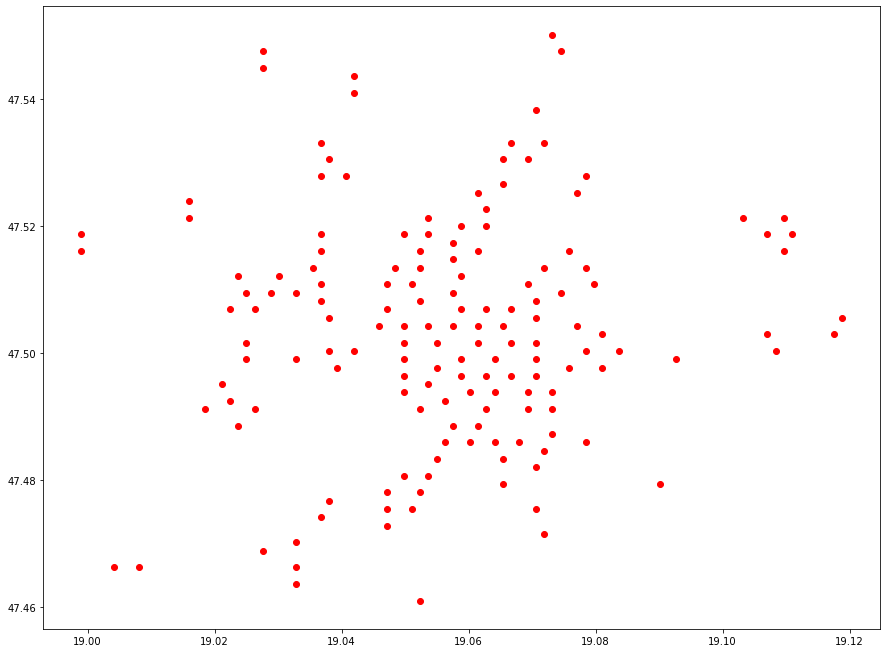

In [39]:
top_100_2 = grid_list_df.iloc[good_index_list].reset_index(drop = True)[0:156]
#ax = top_100_2.plot(column = 'prediction', cmap = 'hot_r', figsize = (15,15))
ax = station_data_df.plot(color = 'blue', figsize = (15,15))
top_100_2.plot(color = 'red', ax=ax)

## Kepler

In [18]:
from keplergl import KeplerGl
map = KeplerGl(height=500)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [33]:
map.add_data(data=grid_list_df_good_indexes[['lon','lat', 'prediction']], name="predicted_station_loc")
map.add_data(data=station_data_df[['Station', 'lon','lat']], name="original_station_loc")

In [34]:
map.config = {'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 47.508314,
   'longitude': 19.062772,
   'pitch': 0,
   'zoom': 11.455802145811225,
   'isSplit': False}}

map.save_to_html(file_name="predicted_stations.html")

Map saved to predicted_stations.html!


### Állomások bővítése - 30 új állomás elhelyezése

In [44]:
## Stations in 300 m
from sklearn.neighbors import KDTree

points = station_data_df.loc[:,['lat','lon']].values.tolist()
#points = overpass_gdf.loc[:,['lat','lon']].values.tolist()
tree = KDTree(points)
nearest_count = tree.query_radius(grid_list_df.loc[:,['lat','lon']],r=0.0027,count_only=True)
grid_list_new_df = grid_list_df
grid_list_new_df['existing_station_nearby'] = nearest_count

In [52]:
grid_list_new_df.shape
grid_list_new_df = grid_list_new_df[grid_list_new_df.existing_station_nearby == 0]
grid_list_new_df.shape

(7029, 44)

(5466, 44)

<AxesSubplot:>

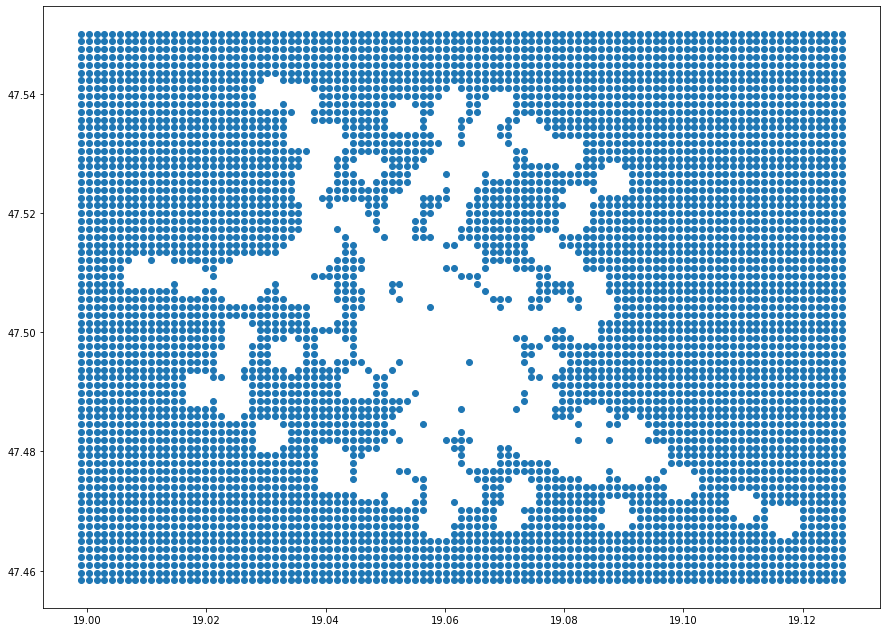

In [55]:
grid_list_new_df.plot(figsize = (15,15))

In [62]:
%%time

grid_list_new_df = grid_list_new_df.sort_values(by = 'prediction', ascending = False).reset_index(drop = True)
index_list = grid_list_new_df.index  

step = 0
good_index = 0
good_index_new_list = []

for i in range(len(index_list)):
    if step == 0:
        good_index = i
        good_index_new_list.append(i)
        step +=1
        continue
    if i not in index_list:
        continue
    else:
        for j in (index_list): # Kidobunk mindent az index listából, ami az i-1. legjobb állomás X méteres körzetében van
            if haversine(grid_list_new_df.iloc[j].lat, grid_list_new_df.iloc[j].lon, grid_list_new_df.iloc[good_index].lat, grid_list_new_df.iloc[good_index].lon) < 250:
                index_list = [x for x in index_list if x != j]
        if haversine(grid_list_new_df.iloc[i].lat, grid_list_new_df.iloc[i].lon, grid_list_new_df.iloc[good_index].lat, grid_list_new_df.iloc[good_index].lon) > 250:
            good_index = i
            good_index_new_list.append(i)
    if len(good_index_new_list) > 30:
        break
    print(str(len(index_list)) + " " +"index: " + str(i) + " good index count: " + str(len(good_index_new_list)) , end = '\r')

Wall time: 2min 9sd index count: 30


In [65]:
grid_list_new_df_good_indexes = (grid_list_new_df.iloc[good_index_new_list])

<AxesSubplot:>

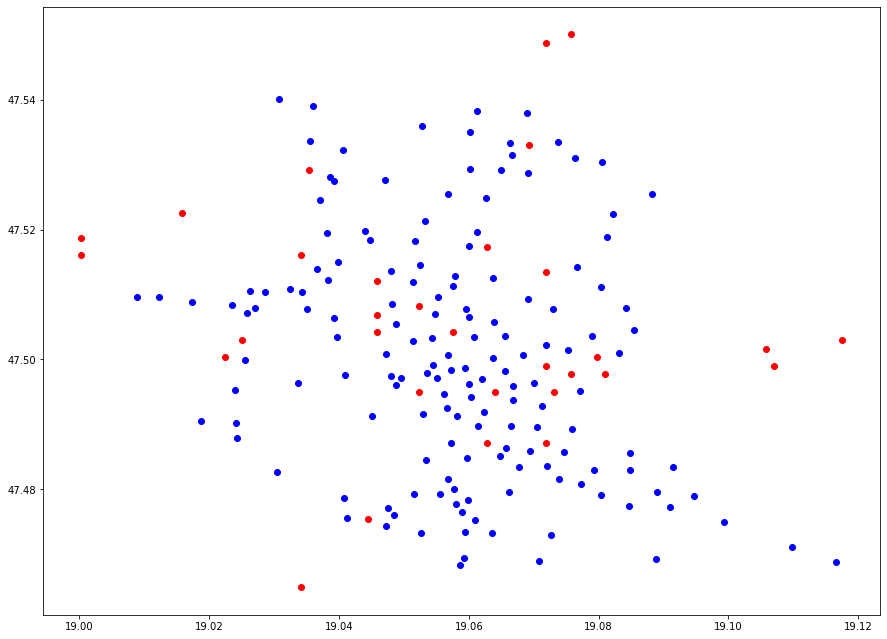

In [69]:
new_stations = grid_list_new_df.iloc[good_index_new_list].reset_index(drop = True)
ax = station_data_df.plot(color = 'blue', figsize = (15,15))
new_stations.plot(color = 'red', ax=ax)

In [68]:
from keplergl import KeplerGl
map = KeplerGl(height=500)

map.add_data(data=grid_list_new_df_good_indexes[['lon','lat', 'prediction']], name="predicted_station_loc")
map.add_data(data=station_data_df[['Station', 'lon','lat']], name="original_station_loc")

map.config = {'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 47.508314,
   'longitude': 19.062772,
   'pitch': 0,
   'zoom': 11.455802145811225,
   'isSplit': False}}

#map.save_to_html(file_name="additional_predicted_stations.html")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to additional_predicted_stations.html!
